<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/molecular_vectorization_for_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit tqdm
!git clone https://github.com/wkweigel/NotebookExamples.git

import sys
sys.path.insert(0,'/content/NotebookExamples')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 54.1 MB/s eta 0:00:00
Cloning into 'NotebookExamples'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 43 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (43/43), 4.42 MiB | 3.74 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Import Libraries and Modules

In [ ]:
import Modules.ImgGen as ImgGen
import pandas as pd
import io
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers import Activation, Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# @title Load Functions
errors=[]
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator() # idem
    try:
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
        return taut_uncharged_parent_clean_mol
    except:
         errors.append(smiles)
         return('Error')




def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect



def vectorize(mol):
    return chemcepterize_mol(mol, embed=10, res=0.2)

def add_split_df_col(df, split_ratio):
    import math
    n_train = math.floor(len(df) * split_ratio)
    n_test = len(df) - n_train
    n_total = n_train + n_test
    if n_total == len(df):
        split_arr = np.array([1]*int(n_train) + [0]*int(n_test))
        np.random.shuffle(split_arr)
        df['split'] = split_arr
        return(df)
    else:
        sliced_df=df.iloc[:n_total]
        split_arr = np.array([1]*int(n_train) + [0]*int(n_test))
        np.random.shuffle(split_arr)
        sliced_df['split'] = split_arr
        print('The length of the df has been shortened to accomodate the split ratio')
        return(sliced_df)

def preview_vector_images(df):
    plt.figure(figsize=(12, 12))

    for i, row in df.iterrows():
        ax = plt.subplot(3, 3, i + 1)
        img_arr=row['mol_image']
        img_name=row['DEL_ID']
        plt.imshow(img_arr[:,:,:3])
        plt.title(img_name)

def save_vector_image(img_arr, file_name):

    plt.imshow(img_arr[:,:,:3])
    plt.axis('off')
    plt.savefig(file_name+'.png',
                bbox_inches='tight',
                pad_inches=0,
                transparent=True)



def seperate_channel(img_vect,channel):
    color_vect=img_vect[:,:,:3]

    if channel==0:
        color_vect[:,:,1] = 0
        color_vect[:,:,2] = 0
    if channel==1:
        color_vect[:,:,0] = 0
        color_vect[:,:,2] = 0
    if channel==2:
        color_vect[:,:,0] = 0
        color_vect[:,:,1] = 0

    return(color_vect)

def show_channels(vect_list):
    plt.figure(figsize=(12, 12))
    channel_list=['Channel 0','Channel 1', 'Channel 2']
    for i, vect in enumerate(vect_list):
        ax = plt.subplot(3, 3, i + 1)
        img_arr=vect_list[i]
        img_name=channel_list[i]
        plt.imshow(img_arr[:,:,:3])
        plt.title(img_name)

def visualize_color_channel(df,channel):
    figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

    for i, row in df.iterrows():
        ax = axes[i // 3, i % 3] if i < 9 else None

        if ax is not None:
            img_arr = row['mol_image']
            img_name = row['DEL_ID']
            if channel==0:
                ax.imshow(img_arr[:, :, 0], cmap='Reds')
                ax.set_title('Red Channel - {}'.format(img_name))
            if channel==1:
                ax.imshow(img_arr[:, :, 1], cmap='Greens')
                ax.set_title('Green Channel - {}'.format(img_name))
            if channel==2:
                ax.imshow(img_arr[:, :, 2], cmap='Blues')
                ax.set_title('Blue Channel - {}'.format(img_name))

    plt.tight_layout()
    plt.show()


def visualize_color_channels(img_vect):
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(img_vect[:, :, 0], cmap='Reds')
    ax1.set_title('Red Channel')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(img_vect[:, :, 1], cmap='Greens')
    ax2.set_title('Green Channel')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img_vect[:, :, 2], cmap='Blues')
    ax3.set_title('Blue Channel')

    plt.tight_layout()
    plt.show()

Import example screening data and ChEMBL Data and preprocess

In [ ]:
data_csv = "/content/NotebookExamples/Datasets/PARP2_Screening_Data_unzeroed.csv"
data_name= "Set1"
split_ratio=0.2

#extract the CSV data for the Main Dataset
Main_Dataset=ImgGen.MolData(data_csv)

#extract the CSV data for the CHEMBL Dataset
ChEMBL_Dataset=ImgGen.MolData('/content/NotebookExamples/Datasets/CHEMBL_Data.csv')

#Add a column of mol objects to the Data
tqdm_notebook.pandas(desc="Generating Mols")
Main_Dataset.data_df['mols']=Main_Dataset.data_df.DEL_Smiles.progress_apply(Chem.MolFromSmiles)
ChEMBL_Dataset.data_df['mols']=ChEMBL_Dataset.data_df.DEL_Smiles.apply(Chem.MolFromSmiles)

#Add Train/Test flags the Data
Main_Dataset.data_df=add_split_df_col(Main_Dataset.data_df, split_ratio)
ChEMBL_Dataset.data_df=add_split_df_col(ChEMBL_Dataset.data_df, split_ratio)

Generating Mols:   0%|          | 0/58301 [00:00<?, ?it/s]

Test the vectorization on a small subset of each dataset

In [ ]:
#Create sliced test_df of n rows for testing
main_test_df=Main_Dataset.data_df.loc[:8].copy()
ChEMBL_test_df=ChEMBL_Dataset.data_df.loc[:8].copy()

#Add a new column to hold the image vector array for each compound
tqdm_notebook.pandas(desc="Vectorizing Mols")
main_test_df["mol_image"] = main_test_df["mols"].progress_apply(vectorize)
ChEMBL_test_df["mol_image"] = ChEMBL_test_df["mols"].progress_apply(vectorize)

Vectorizing Mols:   0%|          | 0/9 [00:00<?, ?it/s]

Vectorizing Mols:   0%|          | 0/9 [00:00<?, ?it/s]

View a single vectorized image

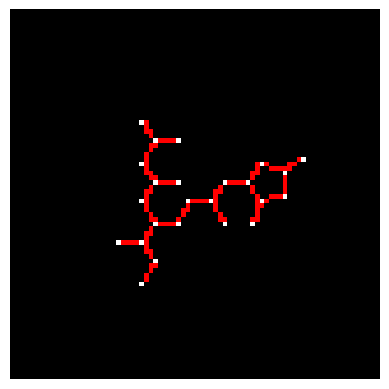

In [ ]:
save_vector_image(main_test_df["mol_image"][0],main_test_df["DEL_ID"][0])

View the individual color channels
* Red= Bond Order
* Green = Atomic Number
* Blue = Partial Charge

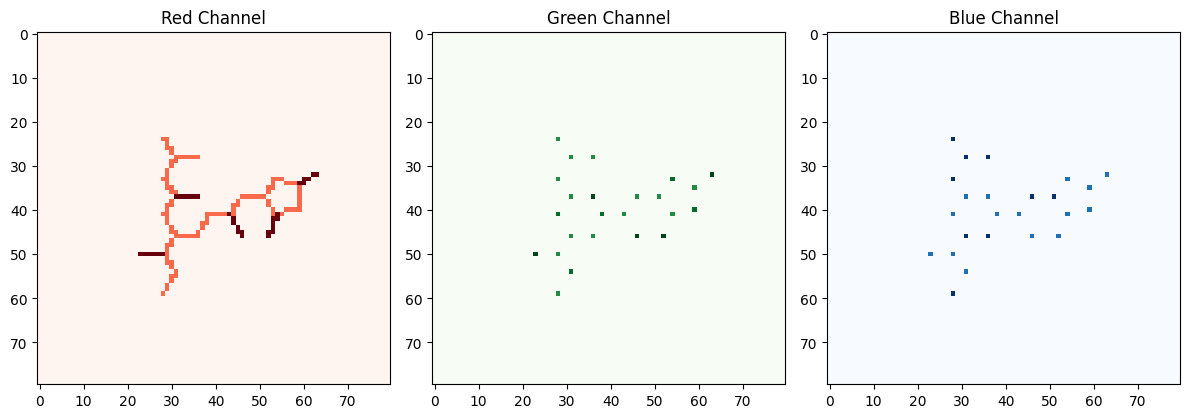

In [ ]:
img_vect=main_test_df['mol_image'][0]
visualize_color_channels(img_vect)

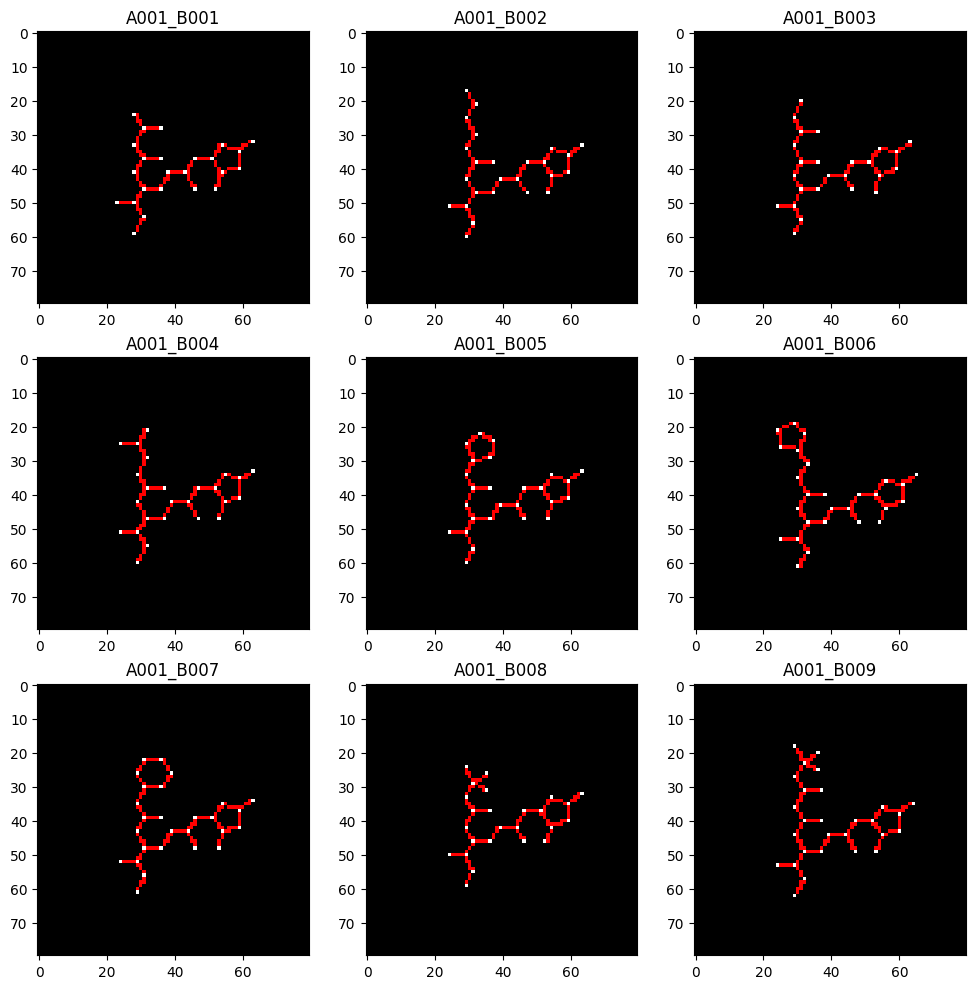

In [ ]:
preview_vector_images(main_test_df)

In [ ]:
split_ratio=0.2
miss_samples=200
hit_samples=200 #max val = 334

#Create seperate dataframes fro hits and misses
Main_Hit_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Hit']
Main_Miss_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Miss']

#We assume Hits<<Misses
#Therefore, only take a random sample of n misses
Sampled_Hits=Main_Hit_df.sample(n=hit_samples)
Sampled_Misses=Main_Miss_df.sample(n=miss_samples)


#Concat all the hits and just sampled misses into the final Main_df, then reset the index values
Main_df=pd.concat([Sampled_Hits, Sampled_Misses], axis=0)
Main_df.reset_index(drop=True, inplace=True)

In [ ]:
data_csv = "/content/NotebookExamples/Datasets/PARP2_Screening_Data_unzeroed.csv"
split_ratio=0.2
miss_samples=200
hit_samples=200 #max val = 334


#extract the CSV data for the Main Dataset
Main_Dataset=ImgGen.MolData(data_csv)

#extract the CSV data for the CHEMBL Dataset
ChEMBL_Dataset=ImgGen.MolData('/content/NotebookExamples/Datasets/CHEMBL_Data.csv')

#Add a column of mol objects to the Data
Main_Dataset.data_df['mols']=Main_Dataset.data_df.DEL_Smiles.apply(Chem.MolFromSmiles)
ChEMBL_Dataset.data_df['mols']=ChEMBL_Dataset.data_df.DEL_Smiles.apply(Chem.MolFromSmiles)

#Add Train/Test flags the Data
Main_Dataset.data_df=add_split_df_col(Main_Dataset.data_df, split_ratio)
ChEMBL_Dataset.data_df=add_split_df_col(ChEMBL_Dataset.data_df, split_ratio)

#Create seperate dataframes fro hits and misses
Main_Hit_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Hit']
Main_Miss_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Miss']

#We assume Hits<<Misses
#Therefore, only take a random sample of n misses
Sampled_Hits=Main_Hit_df.sample(n=hit_samples)
Sampled_Misses=Main_Miss_df.sample(n=miss_samples)


#Concat all the hits and just sampled misses into the final Main_df, then reset the index values
Main_df=pd.concat([Sampled_Hits, Sampled_Misses], axis=0)
Main_df.reset_index(drop=True, inplace=True)


In [ ]:
miss_samples=200
hit_samples=200 #max val = 334

#Create seperate dataframes for hits and misses
Main_Hit_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Hit']
Main_Miss_df=Main_Dataset.data_df.loc[Main_Dataset.data_df['Class'] == 'Miss']

#We assume Hits<<Misses
#Therefore, only take a random sample of n misses
Sampled_Hits=Main_Hit_df.sample(n=hit_samples)
Sampled_Misses=Main_Miss_df.sample(n=miss_samples)


#Concat all the hits and just sampled misses into the final Main_df, then reset the index values
Main_df=pd.concat([Sampled_Hits, Sampled_Misses], axis=0)
Main_df.reset_index(drop=True, inplace=True)

In [ ]:
print('All Hits:',len(Main_Hit_df))
print('All Misses:',len(Main_Miss_df))
print('Smapled Hits:',len(Sampled_Hits))
print('Smapled Misses:',len(Sampled_Misses))
print('Combined:',len(Main_df))

All Hits: 334
All Misses: 57967
Smapled Hits: 200
Smapled Misses: 200
Combined: 400


In [ ]:
#Add a new column to hold the image vector array for each compound
tqdm_notebook.pandas(desc="Vectorizing Mols")
Main_df["mol_image"] = Main_df["mols"].progress_apply(vectorize)

Vectorizing Mols:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
X_train = np.array(list(Main_df["mol_image"][Main_df["split"]==1]))
X_test = np.array(list(Main_df["mol_image"][Main_df["split"]==0]))

print(X_train.shape)
print(X_test.shape)

(71, 100, 100, 4)
(329, 100, 100, 4)


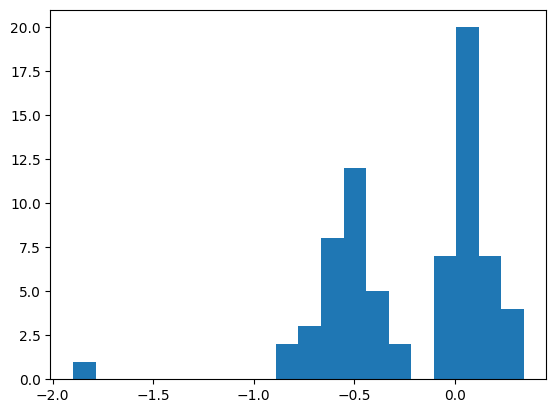

In [ ]:
y_train = Main_df['PARP2 AVG'][Main_df["split"]==1].values.reshape(-1,1)
y_test = Main_df['PARP2 AVG'][Main_df["split"]==0].values.reshape(-1,1)
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train_s = rbs.fit_transform(np.log(y_train))
y_test_s = rbs.transform(np.log(y_test))
h = plt.hist(y_train_s, bins=20)

In [ ]:
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

input_shape = X_train.shape[1:]

input_img = Input(shape=input_shape)
x = Inception0(input_img)
x = Inception(x)
x = Inception(x)
od=int(x.shape[1])
x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(1, activation='linear')(x)
model = Model(inputs=input_img, outputs=output)
print(model.summary())

optimizer = Adam(lr=0.00025)
model.compile(loss="mse", optimizer=optimizer)

from keras.preprocessing.image import ImageDataGenerator


generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                               )
#Concatenate for longer epochs
Xt = np.concatenate([X_train]*50, axis=0)
yt = np.concatenate([y_train]*50, axis=0)
batch_size=128
g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
steps_per_epoch = 10000/batch_size


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 100, 16)         80        ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 100, 100, 16)         80        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 100, 100, 16)         2320      ['conv2d[0][0]']              
                                                                                              

None


 **Note: If you are running the notebook from colab, be sure that T4 GPU acceleration is enabled or training the model will take forever.** <br>
 Edit>Notebook Settings> Hardware Accelerator

In [ ]:
history=model.fit(X_train,
                  y_train,
                  validation_data=(X_test,y_test),
                  epochs=30,
                  shuffle=True)

Epoch 1/30
3/3 [==============================] - 18s 575ms/step - loss: 241.0941 - val_loss: 988.7054
Epoch 2/30
3/3 [==============================] - 0s 207ms/step - loss: 207.1110 - val_loss: 951.0337
Epoch 3/30
3/3 [==============================] - 0s 207ms/step - loss: 186.8496 - val_loss: 936.7781
Epoch 4/30
3/3 [==============================] - 0s 167ms/step - loss: 189.6474 - val_loss: 931.0014
Epoch 5/30
3/3 [==============================] - 0s 207ms/step - loss: 191.5594 - val_loss: 925.7844
Epoch 6/30
3/3 [==============================] - 0s 166ms/step - loss: 185.7457 - val_loss: 922.0778
Epoch 7/30
3/3 [==============================] - 0s 164ms/step - loss: 179.7703 - val_loss: 921.0116
Epoch 8/30
3/3 [==============================] - 0s 166ms/step - loss: 176.5571 - val_loss: 919.7493
Epoch 9/30
3/3 [==============================] - 0s 207ms/step - loss: 173.6684 - val_loss: 920.3608
Epoch 10/30
3/3 [==============================] - 0s 165ms/step - loss: 172.2118

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)
history = model.fit_generator(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs=150,
                              validation_data=(X_test,y_test),
                              callbacks=[reduce_lr])

<ipython-input-13-1cf9bf22d6c6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(g,


Epoch 1/150
27/27 [==============================] - 19s 557ms/step - loss: 167.3006 - val_loss: 860.7910 - lr: 0.0010
Epoch 2/150
27/27 [==============================] - 14s 505ms/step - loss: 165.2890 - val_loss: 858.3502 - lr: 0.0010
Epoch 3/150
27/27 [==============================] - 15s 533ms/step - loss: 162.4108 - val_loss: 856.0045 - lr: 0.0010
Epoch 4/150
27/27 [==============================] - 14s 533ms/step - loss: 159.1459 - val_loss: 852.8282 - lr: 0.0010
Epoch 5/150
27/27 [==============================] - 14s 508ms/step - loss: 160.3401 - val_loss: 860.6802 - lr: 0.0010
Epoch 6/150
27/27 [==============================] - 14s 506ms/step - loss: 153.4951 - val_loss: 857.6017 - lr: 0.0010
Epoch 7/150
27/27 [==============================] - 14s 505ms/step - loss: 150.2202 - val_loss: 865.8689 - lr: 0.0010
Epoch 8/150
27/27 [==============================] - 15s 547ms/step - loss: 145.7091 - val_loss: 874.6645 - lr: 0.0010
Epoch 9/150
27/27 [=============================

KeyboardInterrupt: ignored

Text(0, 0.5, 'Loss/lr')

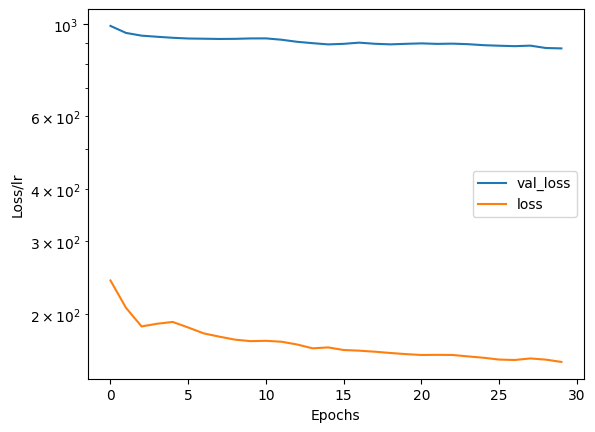

In [ ]:
hist = history.history

for label in ['val_loss','loss']:
    plt.plot(hist[label], label = label)
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss/lr")

11/11 [==============================] - 0s 27ms/step


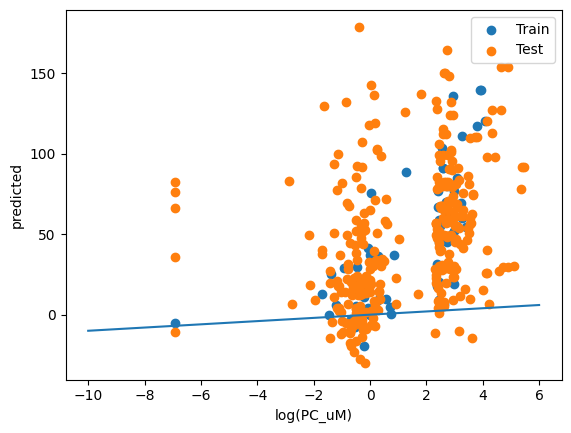

In [ ]:
y_pred_t = rbs.inverse_transform(model.predict(X_train))
y_pred = rbs.inverse_transform(model.predict(X_test))
plt.scatter(np.log(y_train), y_pred_t, label="Train")
plt.scatter(np.log(y_test), y_pred, label="Test")
plt.xlabel("log(PC_uM)")
plt.ylabel("predicted")
plt.plot([-10,6],[-10,6])
plt.legend()

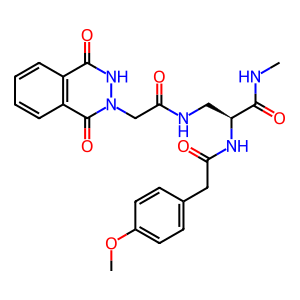

In [ ]:
from rdkit.Chem import Draw
molnum = 143
molimage = np.array(list(Main_df['mol_image'][molnum:molnum+1]))
mol = Main_df['mols'][molnum]

Draw.MolToImage(mol)

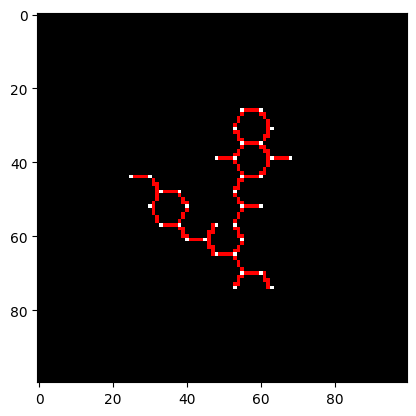

In [ ]:
plt.imshow(molimage[0,:,:,:3])

1/1 [==============================] - 0s 76ms/step


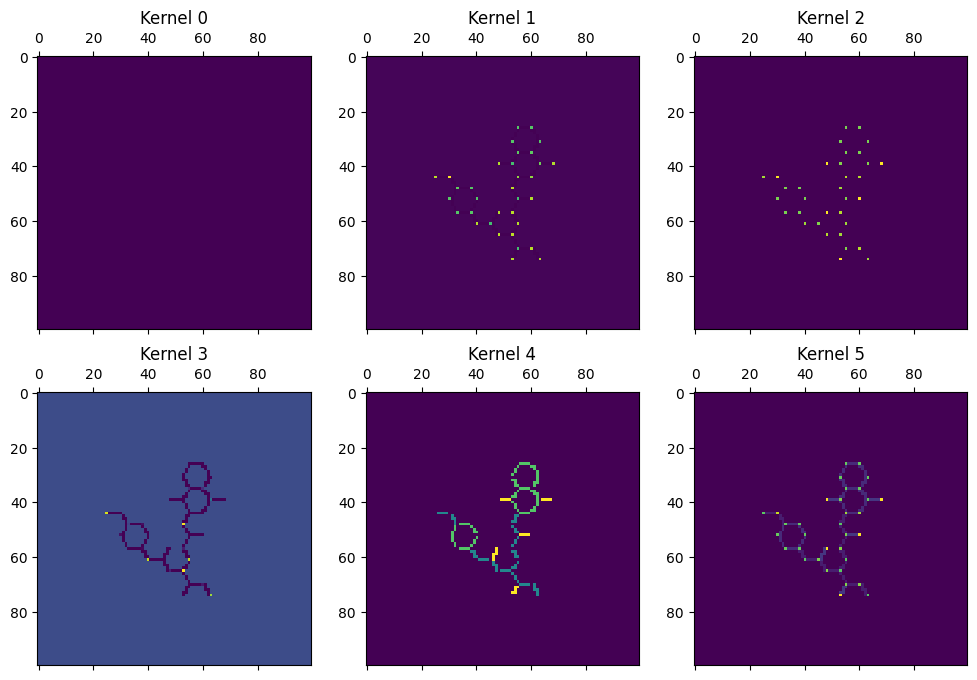

In [ ]:
layer1_model = Model(inputs=model.input,
                    outputs=model.layers[2].output)
kernels1 = layer1_model.predict(molimage)[0]
def plot_kernels(kernels):
    fig, axes = plt.subplots(2,3, figsize=(12,8))
    for i,ax in enumerate(axes.flatten()):
        ax.matshow(kernels[:,:,i])
        ax.set_title("Kernel %s"%i)
plot_kernels(kernels1)

Layer 7
1/1 [==============================] - 0s 171ms/step


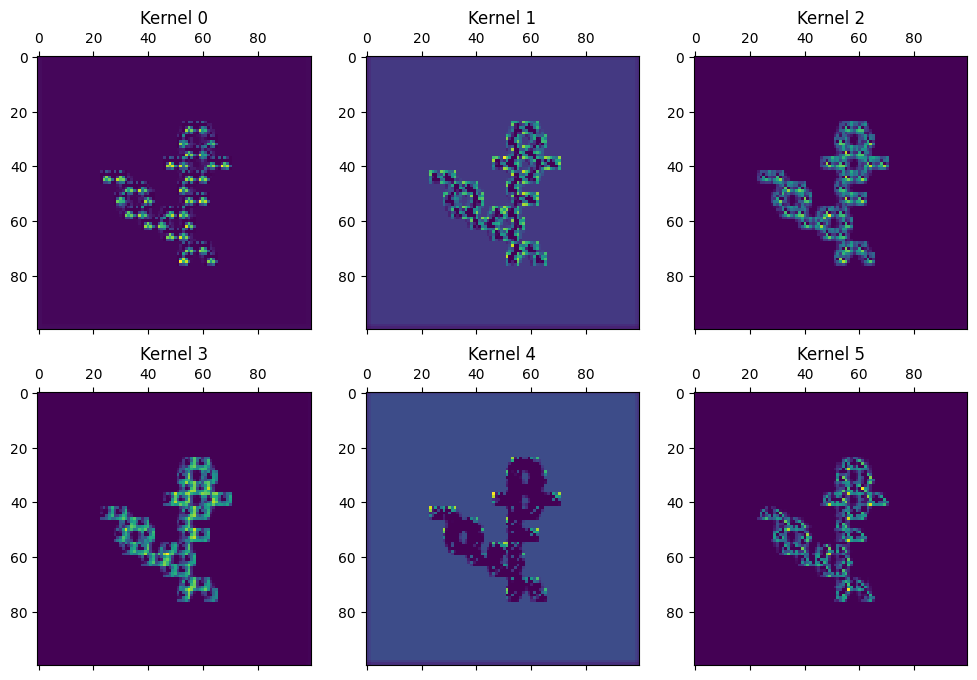

Layer 13
1/1 [==============================] - 0s 101ms/step


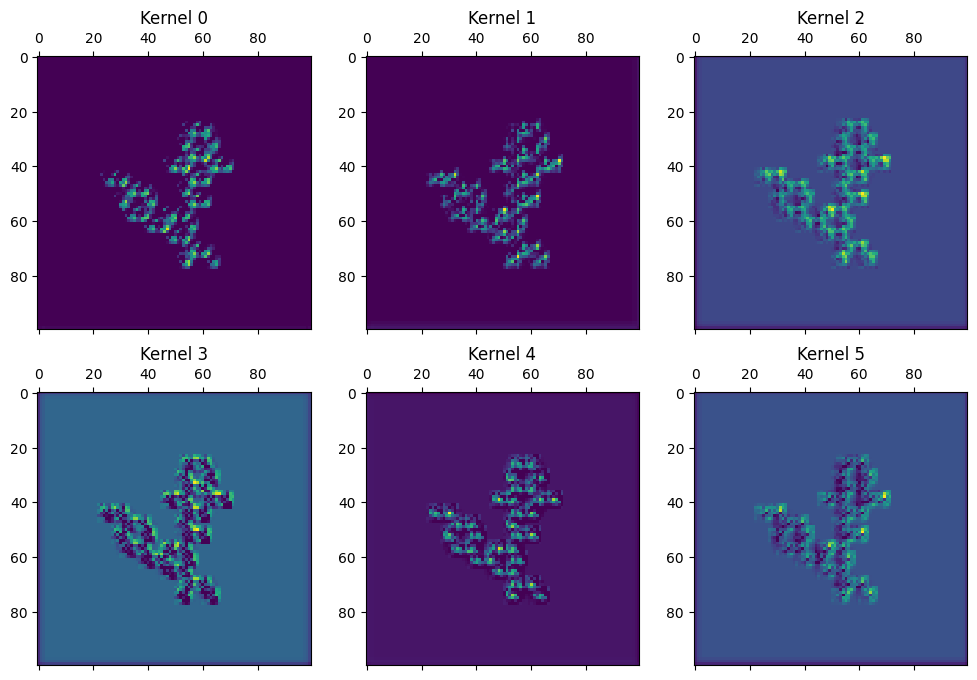

Layer 15
1/1 [==============================] - 0s 110ms/step


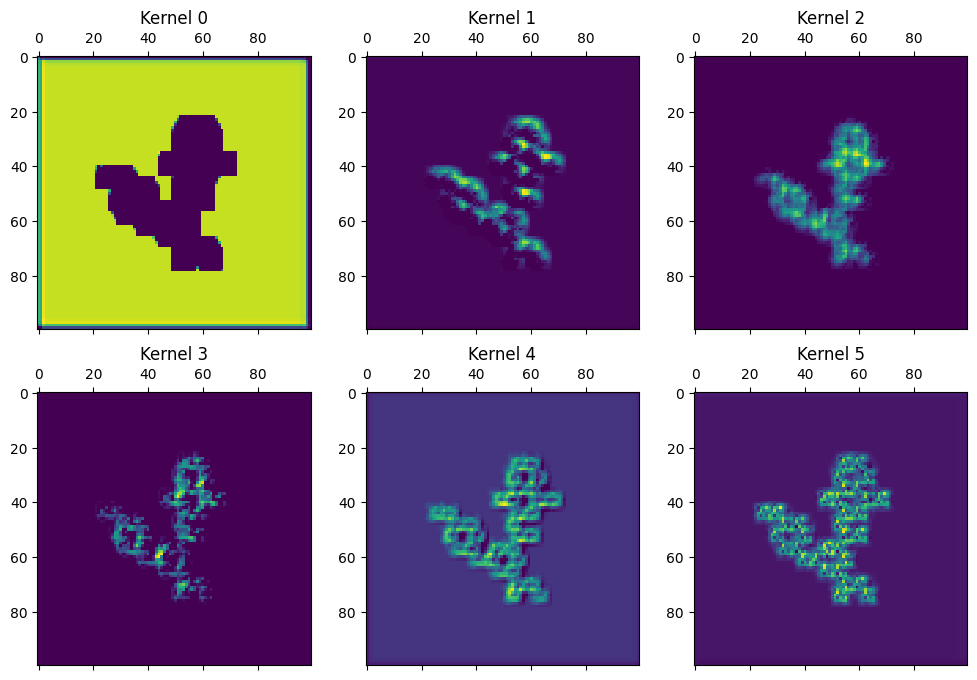

Layer 19
1/1 [==============================] - 0s 114ms/step


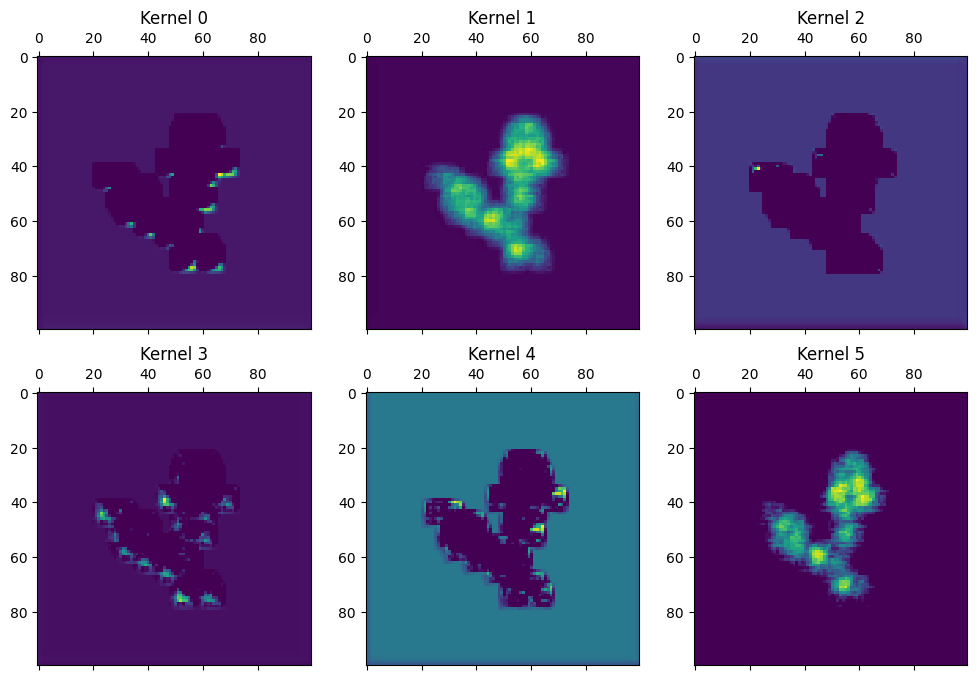

Layer 20
1/1 [==============================] - 0s 132ms/step


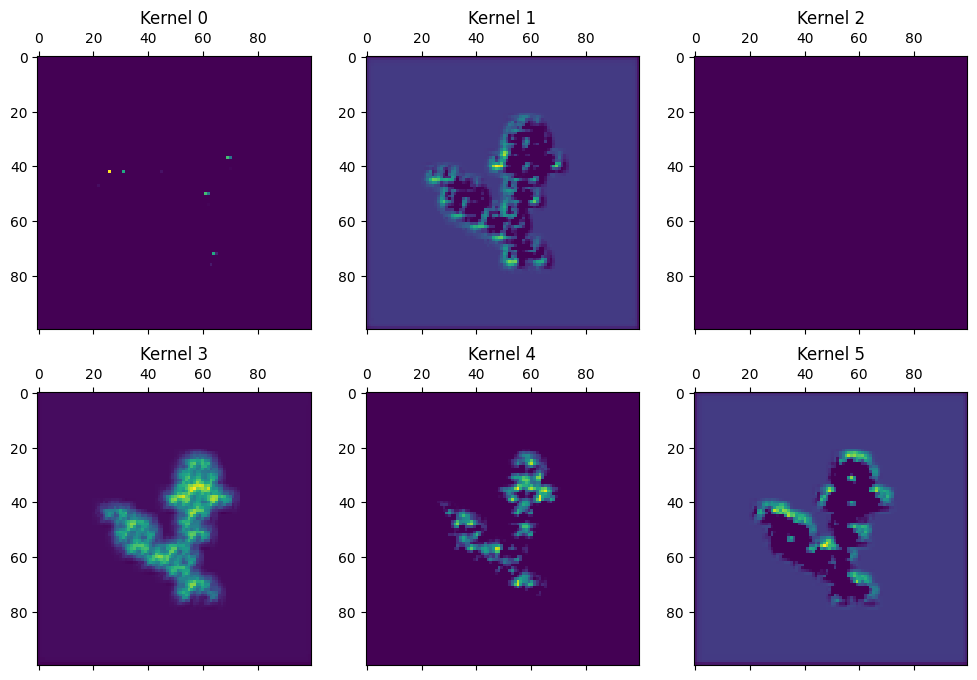

In [ ]:
for layer in [7,13,15,19,20]:
    print("Layer %i"%layer)
    plot_kernels(Model(inputs=model.input,outputs=model.layers[layer].output).predict(molimage)[0])
    plt.show()